# ДЗ 1:

### Дизайн теста
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1. Представим что у нас прошел тест, используем те же самые данные за 2 недели

2. Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3. Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4. Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5. Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

In [ ]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|█████████▉| 78.6M/78.8M [00:04<00:00, 18.5MiB/s]

In [ ]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [ ]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])
interactions['user_id'] = interactions['user_id'].astype(str)

kion dataset download: 100%|██████████| 78.8M/78.8M [00:23<00:00, 18.5MiB/s]

## Дизайн теста
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [ ]:
week2 = interactions[(interactions['last_watch_dt'] >= '2021-08-09') & (interactions['last_watch_dt'] <= '2021-08-22')]
week2['last_watch_dt'].min(), week2['last_watch_dt'].max()

(Timestamp('2021-08-09 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [ ]:
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]

In [ ]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [ ]:
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

##### 2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

In [ ]:
correctness = []
values = []

for i in range(1000): # в дз используем 1000 итераций

    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)
    test_correctness = collections.Counter(correctness)


print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

significance: 4.8%


На семинаре была получена корректность равная 5%. Корректоность на бутстрепе за две недели практически равна корректности за 1 неделю

In [ ]:
p_values = [get_p_value(dist) for dist in values]

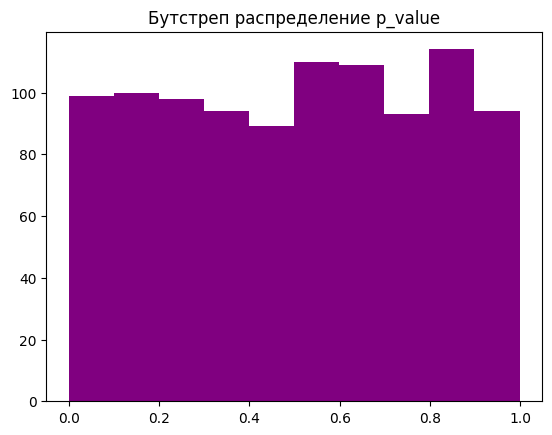

In [ ]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value");

На 10 бинах распределение p_value выглядит довольно равномерным, проверим на равномерность с помощью критерия Колмогорова-Смирнова

In [ ]:
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.6566398438826686 - p_values равномерное распределение


Критерий также указывает на равномерность распределения p_values

##### 3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)


In [ ]:
effects = [1.01, 1.03, 1.05]
correctness = [[] for _ in range(len(effects))]
values = [[] for _ in range(len(effects))]

for i in range(1000):

    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)

    for idx, effect in enumerate(effects):
        sample_b_mean = calc_bootstrap_mean(vec_b * effect, size=1000)
        values[idx].append(sample_a_mean - sample_b_mean)

        left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                      [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

        correctness[idx].append(not left_side <= 0 <= right_side)


for idx, effect in enumerate(effects):
    test_correctness = collections.Counter(correctness[idx])
    print(f'Мощность при эффекте в {round((effect - 1)*100)}%: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

Мощность при эффекте в 1%: 34.0%
Мощность при эффекте в 3%: 99.2%
Мощность при эффекте в 5%: 100.0%


##### 4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

In [ ]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

In [ ]:
# Посмотрим на MDE используя мощность при эффекте в 3%
print(f"MDE = {round(get_mde(week2['total_dur'], 0.048, 0.007), 3)}%")

# Посмотрим на MDE при ожидаемой мощности в 80%
print(f"MDE = {round(get_mde(week2['total_dur'], 0.048, 0.2), 3)}%")

MDE = 1.52%
MDE = 0.966%


Не смог придумать/найти более корректный расчет MDE на бутстрапе

## A/B тест
1. Представим что у нас прошел тест, используем те же самые данные за 2 недели
2. Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

In [ ]:
week2.loc[week2['total_dur'] < 500, 'total_dur'] = 0

##### 3. Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)


In [ ]:
new_df = groups_splitter(
    week2.copy(),
    columns=['user_id', 'total_dur', 'group'],
    user_salt='kiontestmodel20210805'
).drop_duplicates()


vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

##### 4. Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

In [ ]:
# Проверим, что нет дубликатов пользователей
new_df[(new_df['group'] == 'B')]['user_id'].nunique() == vec_b.shape[0]

True

In [ ]:
# Добавим эффект
top_10_users_idx = vec_b.sort_values(ascending=False).index[:int(vec_b.shape[0] * 0.1)]
vec_b[top_10_users_idx] *= 1.025

<ipython-input-198-098ce2f91dba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vec_b[top_10_users_idx] *= 1.025


##### 5. Посчитайте результат такого теста и сделайте выводы (2 балла)




Проведем A/B тест, будем использовать бутстрап

In [ ]:
# посчитаем на бутстрэпе средние для векторов
sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

# считаем разности
dist = sample_a_mean - sample_b_mean

# считаем 95% доверительный интервал для разницы средних
left_side, right_side = np.percentile(
    dist,
     [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]
)

# получаем p_value
p_value = get_p_value(dist)

In [ ]:
left_side, right_side, not left_side <= 0 <= right_side

(-452.18468679774617, -31.428985312187447, True)

Ноль не попал в 95% доверительный интервал -> статистически значимых изменений нет

In [ ]:
if p_value < 0.05:
    print(f'p_value = {p_value} - Есть статистически значимые изменения')
else:
    print(f'p_value = {p_value} - Нет статистически значимых изменений')

p_value = 0.03 - Есть статистически значимые изменения


По результатам проведенного теста был получен p_value = 0.03, что  также говорит о наличии статистически значимых различий между выборками

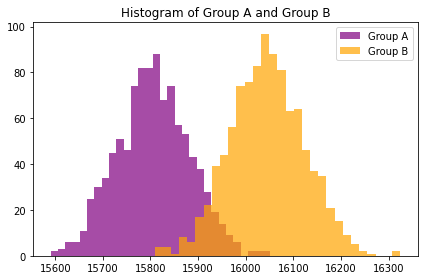

In [ ]:
# Посмотрим на распределение средних двух выборок
plt.hist(sample_a_mean, bins=30, color='purple', alpha=0.7, label='Group A')
plt.hist(sample_b_mean, bins=30, color='orange', alpha=0.7, label='Group B')
plt.title('Histogram of Group A and Group B')
plt.legend()
plt.tight_layout()
plt.show()